In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as data_utils
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
import god_config as config1
dir_path = os.getcwd()

In [2]:
#For SMOTE implementation
#Load the data
# roi = 'HVC'
# X = np.load(dir_path+'/data/Subject1_'+roi+'_fmri.npy')
# datatype=np.load(dir_path+'/data/Subject1_datatype.npy')
X = np.load(dir_path+'/padded_data/VC.npy')
datatype = np.load(dir_path+'/padded_data/datatype.npy')
y = np.zeros((len(datatype),))
y[np.where(datatype == 3)[0]] = 1

print (X.shape)
print (y.shape)

(17250, 45, 29, 22)
(17250,)


In [ ]:
#Split the data and resample with SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
sm = SMOTE(random_state = 2)
X_train, y_train = sm.fit_resample(X_train.reshape(X_train.shape[0],-1), y_train)
X_train = X_train.reshape(-1, X.shape[1], X.shape[2], X.shape[3])

#Convert to pytorch Tensors
X_train = torch.Tensor(X_train).unsqueeze_(1)
y_train = torch.LongTensor(y_train)
X_test = torch.Tensor(X_test).unsqueeze_(1)
y_test = torch.LongTensor(y_test)

#Convert to pytorch Datasets
train_set = data_utils.TensorDataset(X_train, y_train)
test_set = data_utils.TensorDataset(X_test, y_test)

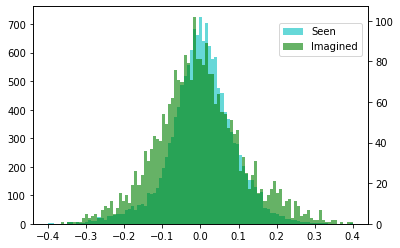

In [6]:
absavgdata = np.average(X.reshape(X.shape[0],-1),axis = 1)
seen = absavgdata[y == 0]
imagined = absavgdata[y==1]
bins = np.linspace(-0.4,0.4 ,100)

fig,ax1 = plt.subplots()
ax1.hist(seen, bins, alpha = 0.6, color = 'c', label = "Seen")
ax2 = ax1.twinx()
ax2.hist(imagined, bins, alpha = 0.6, color = 'g', label = "Imagined")
fig.legend(bbox_to_anchor = (0.85,0.8))
plt.show()

In [3]:
#Note: The classes are unbalance, this is why we implemented SMOTE. 
#SMOTE works by using k nearest neighbors to generate new data of the 
#undersampled class
print ("Original seen samples:\t\t",len(y[y==0]))
print ("Original imagined samples:\t",len(y[y==1]))
print ("New seen samples:\t\t", len(y_train[y_train == 0]))
print ("New imagined samples:\t\t", len(y_train[y_train == 1]))

Original seen samples:		 14750
Original imagined samples:	 2500
New seen samples:		 11828
New imagined samples:		 11828


In [7]:
#Split the data into 5 subsets for 5-fold cross validation
datasetlengths = [len(y_train)//5 for i in range(4)]
datasetlengths.append(len(y_train) - 4*len(y_train)//5) #to account for dataset length not being multiple of 5
datasets = data_utils.random_split(train_set, datasetlengths)

4731


In [8]:
#Create the pytorch Dataloader objects
batch_size = 60
train_loaders = []
for i in range(5):
    train_loader = data_utils.DataLoader(datasets[i],
                                         batch_size = batch_size,
                                         num_workers = 0,
                                         shuffle = True)
    train_loaders.append(train_loader)

test_loader = data_utils.DataLoader(test_set,
                                    batch_size = batch_size,
                                    shuffle = False,
                                    num_workers = 0)

In [9]:
#Define the convolutional neural network model
#Note: Each fmri scan is of size 45 x 29 x 22
class fmriNet(nn.Module):
    def __init__(self):
        super(fmriNet, self).__init__()
        #conv1, conv2, and conv3 maintain input dimensions
        self.conv1 = nn.Sequential(
            nn.Conv3d(1, 8, 3, padding = 1),
            nn.BatchNorm3d(8),
            nn.ReLU())
        self.conv2 = nn.Sequential(
            nn.Conv3d(8, 8, 3, padding = 1),
            nn.BatchNorm3d(8),
            nn.ReLU())
        self.conv3 = nn.Sequential(
            nn.Conv3d(8, 8, 3, padding = 1),
            nn.BatchNorm3d(8),
            nn.ReLU())
        #conv4 changes data to object of size 20 x 13 x 9
        self.conv4 = nn.Sequential(
            nn.Conv3d(8, 16, (7,5,4), stride = (2,2,2)),
            nn.BatchNorm3d(16),
            nn.ReLU())
        
        #conv5, conv6, and conv7 maintain dimensions 20 x 13 x 9
        self.conv5 = nn.Sequential(
            nn.Conv3d(16, 16, 3, padding = 1),
            nn.BatchNorm3d(16),
            nn.ReLU())
        self.conv6 = nn.Sequential(
            nn.Conv3d(16, 16, 3, padding = 1),
            nn.BatchNorm3d(16),
            nn.ReLU())
        self.conv7 = nn.Sequential(
            nn.Conv3d(16, 16, 3, padding = 1),
            nn.BatchNorm3d(16),
            nn.ReLU())
        
        #conv8 changes data to object of size 7 x 5 x 4
        self.conv8 = nn.Sequential(
            nn.Conv3d(16, 32, (8,5,3), stride = (2,2,2)),
            nn.BatchNorm3d(32),
            nn.ReLU())
        
        #conv9, conv10, and conv11 maintain dimensions 7 x 5 x 4
        self.conv9 = nn.Sequential(
            nn.Conv3d(32, 32, 3, padding = 1),
            nn.BatchNorm3d(32),
            nn.ReLU())
        self.conv10 = nn.Sequential(
            nn.Conv3d(32, 32, 3, padding = 1),
            nn.BatchNorm3d(32),
            nn.ReLU())
        self.conv11 = nn.Sequential(
            nn.Conv3d(32, 32, 3, padding = 1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.Dropout(0.5))
        
        #Flatten to vector of length 32 x 7 x 5 x 4 = 4480
        #Fully connected layer from 4480 to 100
        self.fc1 = nn.Sequential(
            nn.Linear(4480, 1000),
            nn.ReLU(),
            nn.Dropout(0.5))
        #Fully connected layer from 100 to 10
        self.fc2 = nn.Sequential(
            nn.Linear(1000,100),
            nn.ReLU(),
            nn.Dropout(0.5))
        self.fc3 = nn.Sequential(
            nn.Linear(100,10),
            nn.ReLU(),
            nn.Dropout(0.5))
        #Fully connected layer from 10 to 2, being the two outputs
        self.fcout = nn.Linear(10,2)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.conv7(out)
        out = self.conv8(out)
        out = self.conv9(out)
        out = self.conv10(out)
        out = self.conv11(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fcout(out)
        return out

In [36]:
#initialize model and move to gpu if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("Running on:",device)
model = fmriNet()
#model = testNet()
model.to(device)

#hyperparameters other than batch size above
learning_rate = 0.0001
betas = (0.9,0.999) #defaults (known to be applicable in most situations according to creator's publication)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas = betas, weight_decay = 0.01)
criterion = nn.CrossEntropyLoss()

Running on: cuda:0


In [37]:
#Function to test the model
def test(model, data_loader):
    total_items = 0
    total_steps = len(data_loader)
    correct = 0
    with torch.no_grad():
        for i, sample in enumerate(data_loader):
            #move data to gpu
            fmris = sample[0].to(device)
            labels = sample[1].to(device)
            total_items += len(labels)
            
            #feed data forward
            outputs = model(fmris)

            _, predicted = torch.max(outputs, 1)
            correct += torch.sum(predicted == labels).item()
            #print ("Step [{}/{}]".format(i+1, total_steps, end = "\r"))
                   
    acc = correct/total_items
    print ("Accuracy: {:.2f}% [{}/{}]".format(acc*100, correct,total_items))
    return acc
    
#Function to perform k-fold cross validation on the model
def kfold(model, train_loaders, num_folds, losses = [], accuracies = []):
    model.train()
    for k in range(num_folds):
        val_index = k
        for i in range(num_folds):
            if i == val_index:
                model.eval() #turns off moving average in batch normalization
                print ("\nTesting accuracy...")
                accuracies.append(test(model,train_loaders[i]))
                model.train()
            else:
                steps_per_epoch = int(datasetlengths[i]/batch_size)
                for j, sample in enumerate(train_loaders[i]):
                    #move data to gpu
                    fmris = sample[0].to(device)
                    labels = sample[1].to(device)

                    #feed data forward
                    outputs = model(fmris)
                    loss = criterion(outputs, labels)
                    losses.append(loss)

                    #backpropagation
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    print ("Training on fold: [{}/{}]\tStep: [{}/{}]\tLoss:{:.10f}".format(i+1,num_folds,j+1,steps_per_epoch, loss), end = "\r")
        plt.plot(losses)
        plt.show()
    return losses, accuracies


Testing accuracy...
Accuracy: 49.10% [2323/4731]


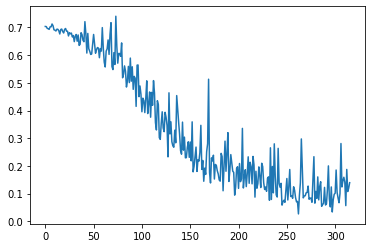

Training on fold: [1/5]	Step: [79/78]	Loss:0.0668381006
Testing accuracy...
Accuracy: 95.84% [4534/4731]


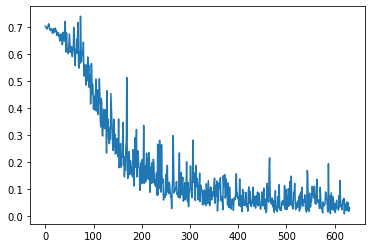

Training on fold: [2/5]	Step: [79/78]	Loss:0.0529451519
Testing accuracy...
Accuracy: 98.20% [4646/4731]


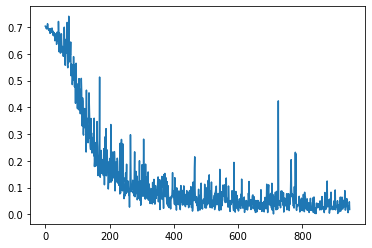

Training on fold: [3/5]	Step: [79/78]	Loss:0.0308427811
Testing accuracy...
Accuracy: 98.27% [4649/4731]


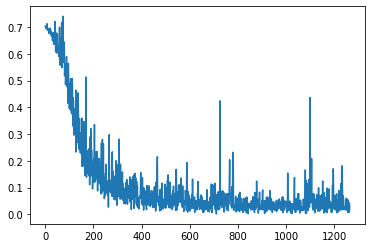

Training on fold: [4/5]	Step: [79/78]	Loss:0.0029959665
Testing accuracy...
Accuracy: 99.58% [4712/4732]


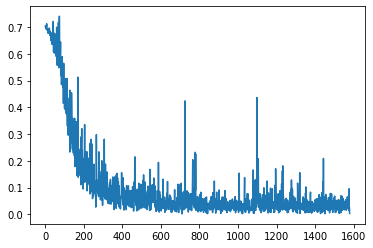

([tensor(0.7035, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(0.7031, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(0.6967, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(0.6953, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(0.6931, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(0.7021, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(0.7022, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(0.7125, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(0.7062, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(0.6914, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(0.6902, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(0.6871, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(0.6937, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(0.6933, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(0.6880, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(0.6764, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor

In [38]:
#run k fold cross validation
losses, accuracies = kfold(model, train_loaders, 5)

In [39]:
#Test with the test dataset
acc = test(model, test_loader)

Accuracy: 89.42% [3085/3450]


In [11]:
model_params = sum(p.numel() for p in model.parameters())
print (model_params)

4769492


In [13]:
#For original WeightedRandomSampler implementation
#Load the fMRI data that we processed to be 3 dimensional rectangles by 
#filling in zeros around the data into X
X=np.load(dir_path+'/data/'+'Subject1'+'_'+'VC'+'_'+'fmri'+'.npy')
X=X.reshape(X.shape[0],X.shape[1],X.shape[2],X.shape[3])
X = torch.Tensor(X).unsqueeze_(1) #need to add a x1 dimension so pytorch doesn't complain when training

#Load the labels: 
# - 0 corresponds to seen data
# - 1 corresponds to imagined data
datatype=np.load(dir_path+'/data/'+'Subject1'+'_'+'datatype'+'.npy')
y = np.zeros((len(datatype),))
y[np.where(datatype == 3)[0]] = 1
y = torch.LongTensor(y)

#Split the data into 80% training, 20% testing
dataset = data_utils.TensorDataset(X, y)
train_set_size = int(0.8 * len(y))
train_set, test_set = data_utils.random_split(dataset, [train_set_size, len(y) - train_set_size])

In [5]:
#fmriNet is better, don't need this one

class testNet(nn.Module):
    def __init__(self):
        super(testNet, self).__init__()
        #45 x 29 x 20
        self.conv1 = nn.Sequential(
            nn.Conv3d(1, 8, (11,6,5)),
            nn.BatchNorm3d(8),
            nn.ReLU())
        #35x24x16
        self.conv2 = nn.Sequential(
            nn.Conv3d(8, 16, (11,6,5)),
            nn.BatchNorm3d(16),
            nn.ReLU())
        #25x19x12
        self.conv3 = nn.Sequential(
            nn.Conv3d(16,32,(11,6,5)),
            nn.BatchNorm3d(32),
            nn.ReLU())
        #15x14x8
        self.conv4 = nn.Sequential(
            nn.Conv3d(32,64,(6,5,3)),
            nn.BatchNorm3d(64),
            nn.ReLU())
        #10x10x6
        self.conv5 = nn.Sequential(
            nn.Conv3d(64,128,(4,4,3)),
            nn.BatchNorm3d(128),
            nn.ReLU())
        #7x7x4
        self.conv6 = nn.Sequential(
            nn.Conv3d(128,256, (4,4,2)),
            nn.BatchNorm3d(256),
            nn.ReLU())
        #4x4x3 x 256 = 12288
        self.fc1 = nn.Sequential(
            nn.Linear(12288, 1000),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(1000,100),
            nn.ReLU())
        self.fcout = nn.Linear(100,2)
        
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fcout(out)
        return out